In [8]:
import sys
sys.path.append("..")
from data.utils import *

import numpy as np
from matplotlib import pyplot as plt
import mne
mne.set_log_level(verbose=None)
import tensorflow as tf
import os
import re
from tqdm import tqdm

from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

ModuleNotFoundError: No module named 'biosig'

In [2]:
N_FILES = -1
LOW_FREQ = 1
HIGH_FREQ = 40

N_CLASSES = 2
N_CHANNELS = 25
N_SAMPLES = 448

WHERE = "kaggle"
if WHERE=="colab":
    BCICIV_PATH = "/content/BCICIV_2a_gdf"
    BATCH_SIZE = 32
elif WHERE=="kaggle":
    BCICIV_PATH = "../input/eeg-data-augmentation/BCICIV_2a_gdf"
    BATCH_SIZE = 64
elif WHERE=="home":
    PATH_LABELS = "../toy_data/BCICIV_2a_gdf"
    BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 2 

FIRST_SPLIT = 0.12
SECOND_SPLIT = 0.15

EPOCHS = 10
LEARNING_RATE = 1e-3

In [4]:
vds = VepessDataset(2)
bds = BCICIV2aDataset(2)

NameError: name 'VepessDataset' is not defined

In [3]:
def load_data():
    files = []
    user_idx = []
    labels = []
    cpt = 0
    for filename in os.listdir(BCICIV_PATH):
        # Get the right number of files
        if cpt >= N_FILES and N_FILES != -1:
            break
        # Get labels
        if "E" in filename:
            labels.append("E")
        elif "T" in filename:
            labels.append("T")
        # Get user idx
        idx = str(re.findall(r'\d+', filename)[0])
        user_idx.append(idx.lstrip("0"))
        data = mne.io.read_raw_gdf(f'{BCICIV_PATH}/{filename}', preload=True)
        data.set_eeg_reference()
        data.filter(l_freq=LOW_FREQ, h_freq=HIGH_FREQ)
#         data = mne.make_fixed_length_epochs(data, duration=5)
        files.append(data)
        cpt += 1
    return files, user_idx, labels

def preprocess_data(data, user_idx, labels):
    # Extracting the data
    d0 = data[0].get_data().T
    d0 = np.array(np.split(d0[:len(d0)-(len(d0)%N_SAMPLES)], len(d0)//N_SAMPLES))
    size = d0.shape[0]*d0.shape[1]
    preprocessed_data = d0
    final_user_idx = [user_idx[0]] * size
    final_labels = [labels[0]] * size
    cpt = 1
    for d in tqdm(data[1:]):
        d = d.get_data().T
        
        d = np.array(np.split(d[:len(d)-(len(d)%N_SAMPLES)], len(d)//N_SAMPLES))
        size = d.shape[0]*d.shape[1]
        preprocessed_data = np.concatenate((preprocessed_data, d), axis=0)
        
        final_user_idx = final_user_idx + [user_idx[cpt]] * size
        final_labels = final_labels + [labels[cpt]] * size
        cpt += 1
    n_ex, n_sample, n_chans = preprocessed_data.shape
    final_user_idx = np.array(list(final_user_idx))
    final_labels = np.array(list(final_labels))
    print("--> This dataset contains", n_ex, "examples,", n_chans, "channels and size of sample is", n_sample)
    print("--> 25 channels: 22 EEG and 3 EOG")
    print("--> Shape of the users and labels arrays:", final_user_idx.shape, final_labels.shape)
    print("--> Final shape of data:", preprocessed_data.shape)
    
    # Normalizing data
    mu = preprocessed_data.mean(-1, keepdims=True)
    preprocessed_data = preprocessed_data - mu
    xmax = preprocessed_data.max(-1, keepdims=True)
    xmin = preprocessed_data.min(-1, keepdims=True)
    preprocessed_data = 2 * (preprocessed_data - xmin) / (xmax - xmin) - 1
    
    # Splitting the data with stratified fold
    split = StratifiedShuffleSplit(n_splits=2, test_size=FIRST_SPLIT, random_state=0)
    final_user_idx = final_user_idx.reshape(preprocessed_data.shape[0], preprocessed_data.shape[1])
    final_labels = final_labels.reshape(preprocessed_data.shape[0], preprocessed_data.shape[1])
    for x_index, test_index in split.split(preprocessed_data, final_user_idx):
        X, X_test = preprocessed_data[x_index], preprocessed_data[test_index]
        y, y_test = final_labels[x_index], final_labels[test_index]
        users, users_test = final_user_idx[x_index], final_user_idx[test_index]
#     print(X.shape, X_test.shape, y.shape, y_test.shape)
#     print(np.unique(users, return_counts=True), np.unique(users_test, return_counts=True))

    split = StratifiedShuffleSplit(n_splits=2, test_size=SECOND_SPLIT, random_state=0)
    for train_index, valid_index in split.split(X, users):
        X_train, X_valid = X[train_index], X[valid_index] 
        y_train, y_valid = y[train_index], y[valid_index]
        users_train, users_valid = users[train_index], users[valid_index]
#     print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
#     print(np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True))

    # Reshape labels for our model
    y_train = y_train.flatten()[::N_SAMPLES]
    y_valid = y_valid.flatten()[::N_SAMPLES]
    y_test = y_test.flatten()[::N_SAMPLES]

    # Check labels
#     print(np.unique(y_train, return_counts=True))
#     print(np.unique(y_valid, return_counts=True))
#     print(np.unique(y_test, return_counts=True))
    
    # Reshape X for our model
    X_train = np.moveaxis(X_train, 2, 1)
    X_valid = np.moveaxis(X_valid, 2, 1)
    X_test = np.moveaxis(X_test, 2, 1)
    
    # Preprocess our labels
    y_train = np.where(y_train=="E", 0, 1)
    y_valid = np.where(y_valid=="E", 0, 1)
    y_test = np.where(y_test=="E", 0, 1)
    y_train = tf.one_hot(y_train, depth=N_CLASSES)
    y_valid = tf.one_hot(y_valid, depth=N_CLASSES)
    y_test = tf.one_hot(y_test, depth=N_CLASSES)
    
    # Check if our split is well done with respect to user indexes
#     print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape)
#     print(np.unique(users_train, return_counts=True), np.unique(users_valid, return_counts=True), np.unique(users_test, return_counts=True))
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test 

def visualize_data():
    pass

def make_tf_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test):
    print(X_train.shape, y_train.shape)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    valid_dataset = valid_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)

    return train_dataset, valid_dataset, test_dataset

In [4]:
data, user_idx, labels = load_data()
X_train, y_train, X_valid, y_valid, X_test, y_test = preprocess_data(data, user_idx, labels)
train_dataset, valid_dataset, test_dataset = make_tf_dataset(X_train, y_train, X_valid, y_valid, X_test, y_test)

Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A04E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660046  =      0.000 ...  2640.184 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A08T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675269  =      0.000 ...  2701.076 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A03E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 648774  =      0.000 ...  2595.096 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A09E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 675097  =      0.000 ...  2700.388 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A06E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 666372  =      0.000 ...  2665.488 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.9s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A06T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 678979  =      0.000 ...  2715.916 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.8s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A02T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 677168  =      0.000 ...  2708.672 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A05E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 679862  =      0.000 ...  2719.448 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A03T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 660529  =      0.000 ...  2642.116 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A07E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673134  =      0.000 ...  2692.536 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A09T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 673327  =      0.000 ...  2693.308 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A08E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 687791  =      0.000 ...  2751.164 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A07T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 681070  =      0.000 ...  2724.280 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A05T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686119  =      0.000 ...  2744.476 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A02E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 662665  =      0.000 ...  2650.660 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A01E.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.6s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Extracting EDF parameters from /kaggle/input/eeg-data-augmentation/BCICIV_2a_gdf/A04T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 600914  =      0.000 ...  2403.656 secs...


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.7s finished
/opt/conda/lib/python3.7/contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.8s finished
100%|██████████| 17/17 [00:13<00:00,  1.24it/s]


--> This dataset contains 26882 examples, 25 channels and size of sample is 448
--> 25 channels: 22 EEG and 3 EOG
--> Shape of the users and labels arrays: (12043136,) (12043136,)
--> Final shape of data: (26882, 448, 25)


2022-11-25 16:17:53.964569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:17:54.070053: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:17:54.072094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:17:54.075589: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

(20107, 25, 448) (20107, 2)


2022-11-25 16:17:57.394721: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1801587200 exceeds 10% of free system memory.
2022-11-25 16:17:59.327152: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1801587200 exceeds 10% of free system memory.
2022-11-25 16:18:00.844880: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 317990400 exceeds 10% of free system memory.
2022-11-25 16:18:01.188359: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 317990400 exceeds 10% of free system memory.
2022-11-25 16:18:01.536886: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 289049600 exceeds 10% of free system memory.


In [5]:
print(np.unique(np.argmax(y_train, axis=1), return_counts=True))
print(np.unique(np.argmax(y_valid, axis=1), return_counts=True))
print(np.unique(np.argmax(y_test, axis=1), return_counts=True))
print(X_train.max(), X_train.min(), X_train.mean(), X_train.std())

(array([0, 1]), array([10212,  9895]))
(array([0, 1]), array([1707, 1842]))
(array([0, 1]), array([1561, 1665]))
1.0 -1.0 0.013386619950259604 0.5775129867433363


In [6]:
def get_callbacks():
    return [
        # ModelCheckpoint(
        #     "best_eegnet.h5", save_best_only=True, monitor="val_loss"
        # ),
        # ReduceLROnPlateau(
        #     monitor="val_top_k_categorical_accuracy",
        #     factor=0.2,
        #     patience=2,
        #     min_lr=0.000001,
        # ),
        EarlyStopping(
            monitor="val_loss",
            min_delta=1e-3,
            patience=10,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        ),
    ]

# https://arxiv.org/pdf/1611.08024.pdf
def EEGNet(n_classes, n_channels=64, n_samples=128, kernel_length=64, n_filters1=8, 
           n_filters2=16, depth_multiplier=2, norm_rate=0.25, dropout_rate=0.5, 
           dropoutType="Dropout"):

    if dropoutType == "SpatialDropout2D":
        dropoutType=SpatialDropout2D
    elif dropoutType == "Dropout":
        dropoutType=Dropout

    inputs = Input(shape=(n_channels, n_samples, 1))

    block1 = Conv2D(n_filters1, (1, kernel_length), padding="same", input_shape=(n_channels, n_samples, 1), use_bias=False)(inputs)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((n_channels, 1), use_bias=False, depth_multiplier=depth_multiplier, depthwise_constraint=max_norm(1.0))(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation("elu")(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = dropoutType(dropout_rate)(block1)

    block2 = SeparableConv2D(n_filters2, (1, 16), use_bias=False, padding="same")(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation("elu")(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = dropoutType(dropout_rate)(block2)
    block2 = Flatten(name="flatten")(block2)

    classifier = Dense(n_classes, name="dense", kernel_constraint=max_norm(norm_rate))(block2)
    classifier = Activation("softmax", name="softmax")(classifier)

    model = Model(inputs=inputs, outputs=classifier) 

    optimizer = Adam(amsgrad=True, learning_rate=LEARNING_RATE)
    loss = BinaryCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            BinaryAccuracy(),
            AUC(),
            Precision(),
            Recall(),
        ],
    )

    model.summary()

    return model

In [7]:
def plot_history_metrics(history):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

In [8]:
model = EEGNet(n_classes=N_CLASSES, n_channels=N_CHANNELS, n_samples=N_SAMPLES)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 448, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 448, 8)        512       
_________________________________________________________________
batch_normalization (BatchNo (None, 25, 448, 8)        32        
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 1, 448, 16)        400       
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 448, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 1, 448, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 112, 16)        0     

In [25]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=get_callbacks(),
    validation_data=valid_dataset,
#     class_weight=???,
)

Epoch 1/10
315/315 [==============================] - 11s 34ms/step - loss: 0.3858 - binary_accuracy: 0.8213 - auc: 0.9061 - precision: 0.8213 - recall: 0.8213 - val_loss: 0.2998 - val_binary_accuracy: 0.8850 - val_auc: 0.9531 - val_precision: 0.8850 - val_recall: 0.8850
Epoch 2/10
315/315 [==============================] - 11s 33ms/step - loss: 0.3849 - binary_accuracy: 0.8216 - auc: 0.9066 - precision: 0.8216 - recall: 0.8216 - val_loss: 0.2942 - val_binary_accuracy: 0.8924 - val_auc: 0.9563 - val_precision: 0.8924 - val_recall: 0.8924
Epoch 3/10
315/315 [==============================] - 11s 35ms/step - loss: 0.3819 - binary_accuracy: 0.8262 - auc: 0.9081 - precision: 0.8262 - recall: 0.8262 - val_loss: 0.2924 - val_binary_accuracy: 0.8887 - val_auc: 0.9542 - val_precision: 0.8887 - val_recall: 0.8887
Epoch 4/10
315/315 [==============================] - 11s 34ms/step - loss: 0.3762 - binary_accuracy: 0.8279 - auc: 0.9110 - precision: 0.8279 - recall: 0.8279 - val_loss: 0.2928 - val

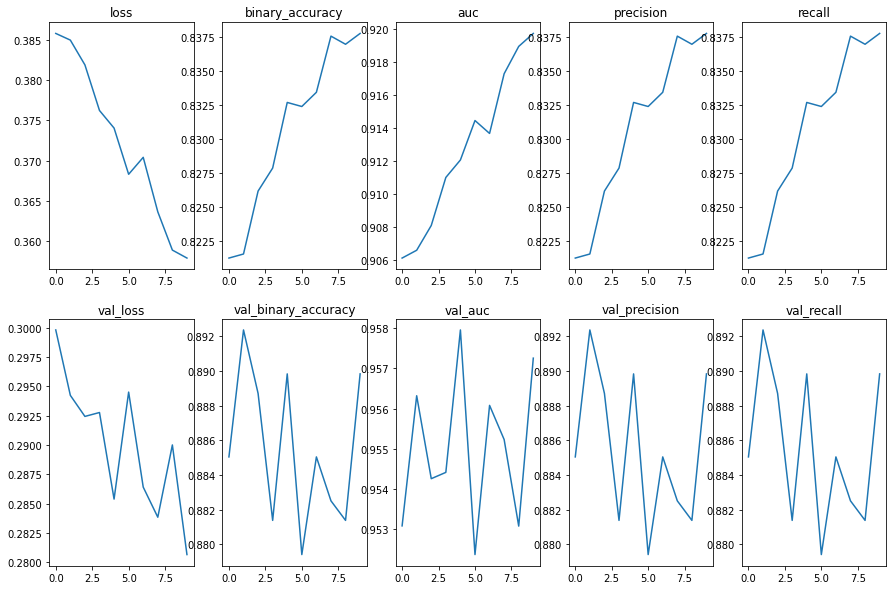

In [26]:
plot_history_metrics(history)

In [27]:
model.evaluate(X_test, y_test, batch_size=8)

404/404 [==============================] - 2s 5ms/step - loss: 0.2835 - binary_accuracy: 0.8828 - auc: 0.9563 - precision: 0.8828 - recall: 0.8828


[0.28349894285202026,
 0.8828270435333252,
 0.956260085105896,
 0.8828270435333252,
 0.8828270435333252]

In [28]:
model.predict(X_test)

array([[9.8216333e-08, 9.9999988e-01],
       [1.4405751e-01, 8.5594249e-01],
       [9.9882656e-01, 1.1734624e-03],
       ...,
       [9.6480834e-01, 3.5191622e-02],
       [5.5133243e-04, 9.9944872e-01],
       [9.7192132e-01, 2.8078705e-02]], dtype=float32)

In [29]:
model.predict(X_test).shape

(3226, 2)

In [30]:
y_test.numpy().shape

(3226, 2)

In [31]:
np.where(model.predict(X_test).argmax(axis=1) == y_test.numpy().argmax(axis=1), 1, 0).mean()

0.8828270303781773

In [32]:
np.unique(model.predict(X_test).argmax(axis=1), return_counts=True)

(array([0, 1]), array([1597, 1629]))